In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

three_months_ago = (datetime.today() - timedelta(days=90)).strftime('%Y-%m-%d')
today = datetime.today().strftime('%Y-%m-%d')
url = f'https://eodhd.com/api/eod/HSI.INDX?from={three_months_ago}&to={today}&period=d&api_token=667ce9a6ed0a88.82288241&fmt=json'

spx = requests.get(url).json()
spx = pd.DataFrame(spx)
spx = spx[['date', 'close']]
spx['date'] = pd.to_datetime(spx['date'])
spx

,date,close
0,2024-04-18,16385.87
1,2024-04-19,16224.14
2,2024-04-22,16511.69
3,2024-04-23,16828.93
4,2024-04-24,17201.27
...,...,...
56,2024-07-11,17832.33
57,2024-07-12,18293.38
58,2024-07-15,18015.94
59,2024-07-16,17727.98


In [2]:
import os
import random
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import sleep,mktime
from datetime import datetime,time,date,timedelta

def get_full_historical_ps_data():
    ### 读取本地的Fireant历史分钟数据
    df1 = pd.read_csv('VN30F1M.csv')
    ### 将Fireant上的数据转化成越南本地时间，使用简单的方法计算，即加上7小时
    df1['Date'] = pd.to_datetime(df1['Date'].apply(lambda x:x.split('+')[0])) + pd.Timedelta(hours=7)
    ### 从entrade上提取数据，设定好开始日期，结束日期
    today_date = int(mktime(pd.Timestamp('2017-01-01').timetuple()))
    end_date = int(mktime((date.today() + pd.Timedelta('1D')).timetuple()))
    ### 结合成url
    url = "https://services.entrade.com.vn/chart-api/chart?from={start_date}&resolution=1&symbol=VN30F1M&to={end_date}".format(start_date=today_date,end_date=end_date)
    headers = {
      'authority': 'services.entrade.com.vn',
      'accept': 'application/json, text/plain, */*',
      'accept-language': 'en-US,en;q=0.9',
      'dnt': '1',
      'origin': 'https://banggia.dnse.com.vn',
      'referer': 'https://banggia.dnse.com.vn/',
      'sec-ch-ua': '"Edge";v="114", "Chromium";v="114", "Not=A?Brand";v="24"',
      'sec-ch-ua-mobile': '?0',
      'sec-ch-ua-platform': '"Windows"',
      'sec-fetch-dest': 'empty',
      'sec-fetch-mode': 'cors',
      'sec-fetch-site': 'cross-site',
      'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36 Edg/114.0.1788.0'}
    ### 读取本地IP文件csv，并且将index设定好
    ip_port = pd.read_csv('ip_port.csv').iloc[:,1:]
    ip_port.index = range(len(ip_port))
    ### 随机选择第n行的ip信息
    random_integer = random.randint(0, len(ip_port)-1)
    ip_port = ip_port.loc[random_integer]
    proxies = {'http':str(ip_port['ip'])+':'+str(ip_port['port'])}
    ### 进行循环获取数据
    ### 设定初始值为0，若重复10此还无法获取数据，则终止
    i = 0
    loop = True
    while loop:
        i = i + 1
        try:
            ### 进行requests，并且在requests中加入proxies和timeout
            df = pd.DataFrame(requests.get(url=url,proxies=proxies,headers=headers,timeout=30).json())
            ### 设定columns名
            df.columns = ['Date','Open','High','Low','Close','Volume','nt']
            ### 修改Datatime的format
            df['Date'] = pd.to_datetime(df['Date'].astype(int).apply(lambda x: datetime.fromtimestamp(x)))
            ### 合并历史数据和最新数据
            df = pd.concat([df1,df])
            ### 优先使用entrade,并且删掉entrade的最后一个columns
            df = df.groupby('Date').head(1).drop('nt',axis=1)
            ### 计算Value和day
            df['Value'] = df['Close'] * df['Volume']
            df['day'] = df['Date'].dt.date
            ### 按照时间降序，并且只选择在time range中的数据
            df = df.sort_values(by='Date',ascending=True)
            df = df.loc[((df['Date'].dt.time>=time(9,0))&(df['Date'].dt.time<=time(13,0)))|((df['Date'].dt.time>=time(13,0))&(df['Date'].dt.time<=time(14,45)))]
            return df
        except:
            pass
        sleep(3)
        if i>=10:
            loop = False
def get_full_historical_index_data():
    ### 读取本地的Fireant历史分钟数据
    df1 = pd.read_csv('VN30.csv')
    ### 将Fireant上的数据转化成越南本地时间，使用简单的方法计算，即加上7小时
    df1['Date'] = pd.to_datetime(df1['Date'].apply(lambda x:x.split('+')[0])) + pd.Timedelta(hours=7)
    ### 从entrade上提取数据，设定好开始日期，结束日期
    today_date = int(mktime(pd.Timestamp('2017-01-01').timetuple()))
    end_date = int(mktime((date.today() + pd.Timedelta('1D')).timetuple()))
    ### 结合成url
    url = "https://services.entrade.com.vn/chart-api/v2/ohlcs/index?from={start_date}&to={end_date}&symbol=VN30&resolution=1".format(start_date=today_date,end_date=end_date)
    headers = {
      'authority': 'services.entrade.com.vn',
      'accept': 'application/json, text/plain, */*',
      'accept-language': 'en-US,en;q=0.9',
      'dnt': '1',
      'origin': 'https://banggia.dnse.com.vn',
      'referer': 'https://banggia.dnse.com.vn/',
      'sec-ch-ua': '"Edge";v="114", "Chromium";v="114", "Not=A?Brand";v="24"',
      'sec-ch-ua-mobile': '?0',
      'sec-ch-ua-platform': '"Windows"',
      'sec-fetch-dest': 'empty',
      'sec-fetch-mode': 'cors',
      'sec-fetch-site': 'cross-site',
      'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36 Edg/114.0.1788.0'}
    ### 读取本地IP文件csv，并且将index设定好
    ip_port = pd.read_csv('ip_port.csv').iloc[:,1:]
    ip_port.index = range(len(ip_port))
    ### 随机选择第n行的ip信息
    random_integer = random.randint(0, len(ip_port)-1)
    ip_port = ip_port.loc[random_integer]
    proxies = {'http':str(ip_port['ip'])+':'+str(ip_port['port'])}
    ### 进行循环获取数据
    ### 设定初始值为0，若重复10此还无法获取数据，则终止
    i = 0
    loop = True
    while loop:
        i = i + 1
        try:
            ### 进行requests，并且在requests中加入proxies和timeout
            df = pd.DataFrame(requests.get(url=url,proxies=proxies,headers=headers,timeout=30).json())
            ### 设定columns名
            df.columns = ['Date','Open','High','Low','Close','Volume','nt']
            ### 修改Datatime的format
            df['Date'] = pd.to_datetime(df['Date'].astype(int).apply(lambda x: datetime.fromtimestamp(x)))
            ### 合并历史数据和最新数据
            df = pd.concat([df1,df])
            ### 优先使用entrade,并且删掉entrade的最后一个columns
            df = df.groupby('Date').head(1).drop('nt',axis=1)
            ### 计算Value和day
            df['Value'] = df['Close'] * df['Volume']
            df['day'] = df['Date'].dt.date
            ### 按照时间降序，并且只选择在time range中的数据
            df = df.sort_values(by='Date',ascending=True)
            df = df.loc[((df['Date'].dt.time>=time(9,0))&(df['Date'].dt.time<=time(13,0)))|((df['Date'].dt.time>=time(13,0))&(df['Date'].dt.time<=time(14,45)))]
            return df
        except:
            pass
        sleep(3)
        if i>=10:
            loop = False


# Specify the path for the new folder
folder_path = os.getcwd().replace('\\','/') + "/vn30f1m_folder/"
# Check if the folder already exists
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

full_historical_ps_data = get_full_historical_ps_data()
full_historical_ps_data.to_pickle('vn30f1mdata.pickle')
full_historical_ps_data.to_pickle(folder_path+'{}.pickle'.format(str(date.today())))
vn30f1m = pd.read_pickle('vn30f1mdata.pickle')

# Specify the path for the new folder
folder_path = os.getcwd().replace('\\','/') + "/vn30_folder/"
# Check if the folder already exists
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

full_historical_index_data = get_full_historical_index_data()
full_historical_index_data.to_pickle('vn30data.pickle')
full_historical_index_data.to_pickle(folder_path+'{}.pickle'.format(str(date.today())))
vn30 = pd.read_pickle('vn30data.pickle')


def get_ps_1(days):
    ### 数据源 entrade
    
    ### 读取本地IP文件csv，并且将index设定好
    ip_port = pd.read_csv('ip_port.csv').iloc[:,1:]
    ip_port.index = range(len(ip_port))
    ### 随机选择第n行的ip信息
    random_integer = random.randint(0, len(ip_port)-1)
    ip_port = ip_port.loc[random_integer]
    proxies = {'http':str(ip_port['ip'])+':'+str(ip_port['port'])}
    
    today_date = int(mktime((date.today() - pd.Timedelta(str(days)+'D')).timetuple()))
    end_date = int(mktime((date.today() + pd.Timedelta('1D')).timetuple()))
    url = "https://services.entrade.com.vn/chart-api/chart?from={start_date}&resolution=1&symbol=VN30F1M&to={end_date}".format(start_date=today_date, end_date=end_date)
    headers = {
      'authority': 'services.entrade.com.vn',
      'accept': 'application/json, text/plain, */*',
      'accept-language': 'en-US,en;q=0.9',
      'dnt': '1',
      'origin': 'https://banggia.dnse.com.vn',
      'referer': 'https://banggia.dnse.com.vn/',
      'sec-ch-ua': '"Edge";v="114", "Chromium";v="114", "Not=A?Brand";v="24"',
      'sec-ch-ua-mobile': '?0',
      'sec-ch-ua-platform': '"Windows"',
      'sec-fetch-dest': 'empty',
      'sec-fetch-mode': 'cors',
      'sec-fetch-site': 'cross-site',
      'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36 Edg/114.0.1788.0'}
    df = pd.DataFrame(requests.get(url=url,headers=headers,proxies=proxies,timeout=3).json()).drop('nextTime',axis=1)
    df.columns = ['Date','Open','High','Low','Close','Volume']
    df['Date'] = pd.to_datetime(df['Date'].astype(int), unit='s') + timedelta(hours=7)
    df['day'] = df['Date'].dt.date
    df['Value'] = df['Volume'] * df['Close']
    df = df[['Date','day','Open','High','Low','Close','Volume','Value']].sort_values(by='Date',ascending=True)
    return df

def get_ps_2(days):
    ### 数据源 vps
    
    ### 读取本地IP文件csv，并且将index设定好
    ip_port = pd.read_csv('ip_port.csv').iloc[:,1:]
    ip_port.index = range(len(ip_port))
    ### 随机选择第n行的ip信息
    random_integer = random.randint(0, len(ip_port)-1)
    ip_port = ip_port.loc[random_integer]
    proxies = {'http':str(ip_port['ip'])+':'+str(ip_port['port'])}
    
    today_date = int(mktime((date.today() - pd.Timedelta(str(days)+'D')).timetuple()))
    end_date = int(mktime((date.today() + pd.Timedelta('1D')).timetuple()))
    url = 'https://histdatafeed.vps.com.vn/tradingview/history?symbol=VN30F1M&resolution=1&from={start_date}&to={end_date}'.format(start_date=today_date, end_date=end_date)
    headers = {
        'Accept':'*/*',
        'Accept-Encoding':'gzip, deflate, br',
        'Accept-Language':'vi-VN,vi;q=0.9,fr-FR;q=0.8,fr;q=0.7,en-US;q=0.6,en;q=0.5,zh-CN;q=0.4,zh;q=0.3',
        'Connection':'keep-alive',
        'Cookie':'_ga=GA1.1.1271176517.1696833379; _ga_790K9595DC=GS1.1.1696833378.1.1.1696833380.0.0.0',
        'Host':'tradingviewrealtime.vps.com.vn',
        'Origin':'https://chart.vps.com.vn',
        'Referer':'https://chart.vps.com.vn/',
        'Sec-Ch-Ua':'"Chromium";v="116", "Not)A;Brand";v="24", "Google Chrome";v="116"',
        'Sec-Ch-Ua-Mobile':'?0',
        'Sec-Ch-Ua-Platform':"Windows",
        'Sec-Fetch-Dest':'empty',
        'Sec-Fetch-Mode':'cors',
        'Sec-Fetch-Site':'same-site',
        'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36}'}
    df = pd.DataFrame(requests.get(url=url,headers=headers,proxies=proxies,timeout=3).json()).drop(['symbol','s'],axis=1)
    df.columns = ['Date','Close','Open','High','Low','Volume']
    df['Date'] = pd.to_datetime(df['Date'].astype(int), unit='s') + timedelta(hours=7)
    df['day'] = df['Date'].dt.date
    df['Value'] = df['Volume'] * df['Close']
    df = df[['Date','day','Open','High','Low','Close','Volume','Value']].sort_values(by='Date',ascending=True)
    return df

def get_ps_3(days):
    ### 数据源 vndirect
    
    ### 读取本地IP文件csv，并且将index设定好
    ip_port = pd.read_csv('ip_port.csv').iloc[:,1:]
    ip_port.index = range(len(ip_port))
    ### 随机选择第n行的ip信息
    random_integer = random.randint(0, len(ip_port)-1)
    ip_port = ip_port.loc[random_integer]
    proxies = {'http':str(ip_port['ip'])+':'+str(ip_port['port'])}
    
    today_date = int(mktime((date.today() - pd.Timedelta(str(days)+'D')).timetuple()))
    end_date = int(mktime((date.today() + pd.Timedelta('1D')).timetuple()))
    url = 'https://dchart-api.vndirect.com.vn/dchart/history?resolution=1&symbol=VN30F1M&from={}&to={}'.format(today_date,end_date)
    headers = {
        'Accept':'application/json, text/plain',
        'Accept-Language':'vi-VN,vi;q=0.9,fr-FR;q=0.8,fr;q=0.7,en-US;q=0.6,en;q=0.5,zh-CN;q=0.4,zh;q=0.3',
        'Connection':'keep-alive',
        'Host':'dchart-api.vndirect.com.vn',
        'Origin':'https://dchart.vndirect.com.vn',
        'Referer':'https://dchart.vndirect.com.vn/',
        'Sec-Ch-Ua':'"Not/A)Brand";v="99", "Google Chrome";v="115", "Chromium";v="115"',
        'Sec-Ch-Ua-Platform':'"Windows"',
        'Sec-Fetch-Dest':'empty',
        'Sec-Fetch-Mode':'cors',
        'Sec-Fetch-Site':'same-site',
        'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36'}
    df = pd.DataFrame(requests.get(url=url,headers=headers,proxies=proxies,timeout=3).json())
    df.columns = ['Date','Close','Open','High','Low','Volume','s']
    df['Date'] = pd.to_datetime(df['Date'].astype(int), unit='s') + timedelta(hours=7)
    df['day'] = df['Date'].dt.date
    df['Value'] = df['Volume'] * df['Close']
    df = df[['Date','day','Open','High','Low','Close','Volume','Value']].sort_values(by='Date')
    return df


def get_vn_1(days):
    ### 数据源 entrade
    
    ### 读取本地IP文件csv，并且将index设定好
    ip_port = pd.read_csv('ip_port.csv').iloc[:,1:]
    ip_port.index = range(len(ip_port))
    ### 随机选择第n行的ip信息
    random_integer = random.randint(0, len(ip_port)-1)
    ip_port = ip_port.loc[random_integer]
    proxies = {'http':str(ip_port['ip'])+':'+str(ip_port['port'])}
    
    today_date = int(mktime((date.today() - pd.Timedelta(str(days)+'D')).timetuple()))
    end_date = int(mktime((date.today() + pd.Timedelta('1D')).timetuple()))
    url = "https://services.entrade.com.vn/chart-api/v2/ohlcs/index?from={start_date}&to={end_date}&symbol=VN30&resolution=1".format(start_date=today_date,end_date=end_date)
    headers = {
      'authority': 'services.entrade.com.vn',
      'accept': 'application/json, text/plain, */*',
      'accept-language': 'en-US,en;q=0.9',
      'dnt': '1',
      'origin': 'https://banggia.dnse.com.vn',
      'referer': 'https://banggia.dnse.com.vn/',
      'sec-ch-ua': '"Edge";v="114", "Chromium";v="114", "Not=A?Brand";v="24"',
      'sec-ch-ua-mobile': '?0',
      'sec-ch-ua-platform': '"Windows"',
      'sec-fetch-dest': 'empty',
      'sec-fetch-mode': 'cors',
      'sec-fetch-site': 'cross-site',
      'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36 Edg/114.0.1788.0'}
    df = pd.DataFrame(requests.get(url=url,headers=headers,proxies=proxies,timeout=3).json()).drop('nextTime',axis=1)
    df.columns = ['Date','Open','High','Low','Close','Volume']
    df['Date'] = pd.to_datetime(df['Date'].astype(int), unit='s') + timedelta(hours=7)
    df['day'] = df['Date'].dt.date
    df['Value'] = df['Volume'] * df['Close']
    df = df[['Date','day','Open','High','Low','Close','Volume','Value']].sort_values(by='Date',ascending=True)
    return df

def get_vn_2(days):
    ### 数据源 vps
    
    ### 读取本地IP文件csv，并且将index设定好
    ip_port = pd.read_csv('ip_port.csv').iloc[:,1:]
    ip_port.index = range(len(ip_port))
    ### 随机选择第n行的ip信息
    random_integer = random.randint(0, len(ip_port)-1)
    ip_port = ip_port.loc[random_integer]
    proxies = {'http':str(ip_port['ip'])+':'+str(ip_port['port'])}
    
    today_date = int(mktime((date.today() - pd.Timedelta(str(days)+'D')).timetuple()))
    end_date = int(mktime((date.today() + pd.Timedelta('1D')).timetuple()))
    url = 'https://histdatafeed.vps.com.vn/tradingview/history?symbol=VN30&resolution=1&from={start_date}&to={end_date}'.format(start_date=today_date, end_date=end_date)
    headers = {
        'Accept':'*/*',
        'Accept-Encoding':'gzip, deflate, br',
        'Accept-Language':'vi-VN,vi;q=0.9,fr-FR;q=0.8,fr;q=0.7,en-US;q=0.6,en;q=0.5,zh-CN;q=0.4,zh;q=0.3',
        'Connection':'keep-alive',
        'Cookie':'_ga=GA1.1.1271176517.1696833379; _ga_790K9595DC=GS1.1.1696833378.1.1.1696833380.0.0.0',
        'Host':'tradingviewrealtime.vps.com.vn',
        'Origin':'https://chart.vps.com.vn',
        'Referer':'https://chart.vps.com.vn/',
        'Sec-Ch-Ua':'"Chromium";v="116", "Not)A;Brand";v="24", "Google Chrome";v="116"',
        'Sec-Ch-Ua-Mobile':'?0',
        'Sec-Ch-Ua-Platform':"Windows",
        'Sec-Fetch-Dest':'empty',
        'Sec-Fetch-Mode':'cors',
        'Sec-Fetch-Site':'same-site',
        'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36}'}
    df = pd.DataFrame(requests.get(url=url,headers=headers,proxies=proxies,timeout=3).json()).drop(['symbol','s'],axis=1)
    df.columns = ['Date','Close','Open','High','Low','Volume']
    df['Date'] = pd.to_datetime(df['Date'].astype(int), unit='s') + timedelta(hours=7)
    df['day'] = df['Date'].dt.date
    df['Value'] = df['Volume'] * df['Close']
    df = df[['Date','day','Open','High','Low','Close','Volume','Value']].sort_values(by='Date',ascending=True)
    return df

def get_vn_3(days):
    ### 数据源 vndirect
    
    ### 读取本地IP文件csv，并且将index设定好
    ip_port = pd.read_csv('ip_port.csv').iloc[:,1:]
    ip_port.index = range(len(ip_port))
    ### 随机选择第n行的ip信息
    random_integer = random.randint(0, len(ip_port)-1)
    ip_port = ip_port.loc[random_integer]
    proxies = {'http':str(ip_port['ip'])+':'+str(ip_port['port'])}
    
    today_date = int(mktime((date.today() - pd.Timedelta(str(days)+'D')).timetuple()))
    end_date = int(mktime((date.today() + pd.Timedelta('1D')).timetuple()))
    url = 'https://dchart-api.vndirect.com.vn/dchart/history?resolution=1&symbol=VN30&from={}&to={}'.format(today_date,end_date)
    headers = {
        'Accept':'application/json, text/plain',
        'Accept-Language':'vi-VN,vi;q=0.9,fr-FR;q=0.8,fr;q=0.7,en-US;q=0.6,en;q=0.5,zh-CN;q=0.4,zh;q=0.3',
        'Connection':'keep-alive',
        'Host':'dchart-api.vndirect.com.vn',
        'Origin':'https://dchart.vndirect.com.vn',
        'Referer':'https://dchart.vndirect.com.vn/',
        'Sec-Ch-Ua':'"Not/A)Brand";v="99", "Google Chrome";v="115", "Chromium";v="115"',
        'Sec-Ch-Ua-Platform':'"Windows"',
        'Sec-Fetch-Dest':'empty',
        'Sec-Fetch-Mode':'cors',
        'Sec-Fetch-Site':'same-site',
        'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36'}
    df = pd.DataFrame(requests.get(url=url,headers=headers,proxies=proxies,timeout=3).json())
    df.columns = ['Date','Close','Open','High','Low','Volume','s']
    df['Date'] = pd.to_datetime(df['Date'].astype(int), unit='s') + timedelta(hours=7)
    df['day'] = df['Date'].dt.date
    df['Value'] = df['Volume'] * df['Close']
    df = df[['Date','day','Open','High','Low','Close','Volume','Value']].sort_values(by='Date')
    return df


# 定义开始时间和结束时间
start_time_morning = datetime(2023, 1, 1, 9, 0)
end_time_morning = datetime(2023, 1, 1, 11, 30)

start_time_afternoon = datetime(2023, 1, 1, 13, 0)
end_time_afternoon = datetime(2023, 1, 1, 14, 30)

start_time_atc = datetime(2023, 1, 1, 14, 46)
end_time_atc = datetime(2023, 1, 1, 14, 47)

# 定义时间间隔为 30 秒钟
interval = timedelta(seconds=30)

# 生成上午时间范围内的分钟列表
morning_minutes = []
current_time = start_time_morning
while current_time <= end_time_morning:
    morning_minutes.append(current_time.time())
    current_time += interval

# 生成下午时间范围内的分钟列表
afternoon_minutes = []
current_time = start_time_afternoon
while current_time <= end_time_afternoon:
    afternoon_minutes.append(current_time.time())
    current_time += interval
    
# 生成ATC时间范围内的分钟列表
atc_minutes = []
current_time = start_time_atc
while current_time <= end_time_atc:
    atc_minutes.append(current_time.time())
    current_time += interval

# 合并两个时间范围的分钟列表
all_minutes = morning_minutes + afternoon_minutes + atc_minutes

def get_ps(days):
    loop_ture = True
    if datetime.now().time()<=time(14,45):
        while loop_ture:
            try:
                df = get_ps_1(days)
                if ((datetime.now() - df.loc[(df['Date'].dt.date==date.today())]['Date'].max()).total_seconds()/60) <= 2.5:
                    loop_ture = False
                    return df
            except:
                pass
            try:
                df = get_ps_2(days)
                if ((datetime.now() - df.loc[(df['Date'].dt.date==date.today())]['Date'].max()).total_seconds()/60) <= 2.5:
                    loop_ture = False
                    return df
            except:
                pass
            try:
                df = get_ps_3(days)
                if ((datetime.now() - df.loc[(df['Date'].dt.date==date.today())]['Date'].max()).total_seconds()/60) <= 2.5:
                    loop_ture = False
                    return df
            except:
                pass
    else:
        while loop_ture:
            try:
                df = get_ps_1(days)
                loop_ture = False
                return df
            except:
                pass
            try:
                df = get_ps_2(days)
                loop_ture = False
                return df
            except:
                pass
            try:
                df = get_ps_3(days)
                loop_ture = False
                return df
            except:
                pass

def get_vn(days):
    loop_ture = True
    if datetime.now().time()<=time(14,45):
        while loop_ture:
            try:
                df = get_vn_1(days)
                if ((datetime.now() - df.loc[(df['Date'].dt.date==date.today())]['Date'].max()).total_seconds()/60) <= 2.5:
                    loop_ture = False
                    return df
            except:
                pass
            try:
                df = get_vn_2(days)
                if ((datetime.now() - df.loc[(df['Date'].dt.date==date.today())]['Date'].max()).total_seconds()/60) <= 2.5:
                    loop_ture = False
                    return df
            except:
                pass
            try:
                df = get_vn_3(days)
                if ((datetime.now() - df.loc[(df['Date'].dt.date==date.today())]['Date'].max()).total_seconds()/60) <= 2.5:
                    loop_ture = False
                    return df
            except:
                pass
    else:
        while loop_ture:
            try:
                df = get_vn_1(days)
                loop_ture = False
                return df
            except:
                pass
            try:
                df = get_vn_2(days)
                loop_ture = False
                return df
            except:
                pass
            try:
                df = get_vn_3(days)
                loop_ture = False
                return df
            except:
                pass


for requests_time_loc,requests_time in enumerate(all_minutes):
    while (datetime.now().time()<all_minutes[0]):
        sleep(3)
    ### 思路：每十秒钟request一次，但是因为每次都会消耗时间，因此request之后sleep会导致越来越偏离
    ### 因此选择时间区间进行一次request
    ### 当前时间大于request_time且小于下一次request_time的时候才进行request
    ### 若是当前时间大于或等于最后一个request_time，则直接进行request然后输出

    ### 查看是否是最后的request_time区间
    if requests_time_loc!=len(all_minutes)-1:
        ### 检查当前时间是否处于该区间
        if (datetime.now().time()>=all_minutes[requests_time_loc]) and (datetime.now().time()<=all_minutes[requests_time_loc+1]):
            ### 进行request
            ps = get_ps(days=2)
            vn = get_vn(days=2)
            ### 读取完整数据，concat，然后去重
            real_time_full_vn30f1m = pd.concat([vn30f1m,ps]).groupby('Date').head(1).copy()
            real_time_full_vn30 = pd.concat([vn30,vn]).groupby('Date').head(1).copy()
            ### 保存该数据到pickle
            real_time_full_vn30f1m.to_pickle('vn30f1m.pickle')
            real_time_full_vn30.to_pickle('vn30.pickle')



        while (datetime.now().time()<all_minutes[requests_time_loc+1]):
            pass
    ### 若是最后一次request
    if (requests_time_loc==(len(all_minutes)-1)):
        ### 进行request
        ps = get_ps(days=2)
        vn = get_vn(days=2)
        ### 读取完整数据，concat，然后去重
        real_time_full_vn30f1m = pd.concat([vn30f1m,ps]).groupby('Date').head(1).copy()
        real_time_full_vn30 = pd.concat([vn30,vn]).groupby('Date').head(1).copy()
        ### 保存该数据到pickle
        real_time_full_vn30f1m.to_pickle('vn30f1m.pickle')
        real_time_full_vn30.to_pickle('vn30.pickle')

In [5]:
import pickle

file_path = 'vn30f1m.pickle'

with open(file_path, 'rb') as f:
    vn30f1m = pickle.load(f)
vn30f1m = vn30f1m[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Value']]
vn30f1m

,Date,Open,High,Low,Close,Volume,Value
0,2018-08-13 09:00:00,943.5,943.5,942.9,942.9,975,919327.5
1,2018-08-13 09:01:00,943.0,943.1,942.9,943.1,220,207482.0
2,2018-08-13 09:02:00,943.0,943.6,943.0,943.5,121,114163.5
3,2018-08-13 09:03:00,943.3,943.4,943.3,943.4,135,127359.0
4,2018-08-13 09:04:00,943.2,943.2,943.0,943.1,361,340459.1
...,...,...,...,...,...,...,...
326367,2024-07-08 14:27:00,1310.8,1311.3,1310.5,1310.5,970,1271185.0
326368,2024-07-08 14:28:00,1310.6,1311.3,1310.6,1311.1,978,1282255.8
326369,2024-07-08 14:29:00,1311.2,1313.0,1311.1,1312.0,3484,4571008.0
326370,2024-07-08 14:30:00,1312.9,1312.9,1312.9,1312.9,94,123412.6


In [5]:
from sqlalchemy import create_engine, inspect
import pandas as pd

def read_from_postgresql(table_name, user, password, host, port, dbname, schema):
    engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}')
    # Read the table into a DataFrame
    df = pd.read_sql_table(table_name, engine, schema=schema)

    return df

host = '192.168.1.35'
port = '5432' 
dbname = 'postgres'
user = 'postgres'
password = 'gtech1234'
schema = 'public'
symbol = 'vn30f1m'

vn30f1m = read_from_postgresql(symbol, user, password, host, port, dbname, schema)
vn30f1m

,Date,Open,High,Low,Close,Volume,basis
0,2018-08-13 09:00:00,943.5,943.5,942.9,942.9,975.0,NaN
1,2018-08-13 09:01:00,943.0,943.1,942.9,943.1,220.0,NaN
2,2018-08-13 09:02:00,943.0,943.6,943.0,943.5,121.0,NaN
3,2018-08-13 09:03:00,943.3,943.4,943.3,943.4,135.0,NaN
4,2018-08-13 09:04:00,943.2,943.2,943.0,943.1,361.0,NaN
...,...,...,...,...,...,...,...
366831,2024-07-16 14:26:00,1301.6,1302.0,1301.1,1301.5,1229.0,1.00
366832,2024-07-16 14:27:00,1301.5,1301.9,1301.5,1301.6,527.0,0.32
366833,2024-07-16 14:28:00,1301.6,1302.3,1301.2,1301.2,1324.0,0.59
366834,2024-07-16 14:29:00,1301.5,1301.8,1301.5,1301.8,1161.0,0.56


In [3]:
def generate_time_slots(start, end, interval_minutes):
    time_slots = []
    current_time = start
    while current_time < end:
        time_slots.append(current_time)
        current_time += timedelta(minutes=interval_minutes)
    return time_slots

def create_valid_times():
    valid_times = []
    morning_session = generate_time_slots(datetime.strptime("09:00", "%H:%M"), datetime.strptime("11:30", "%H:%M"), 1)
    afternoon_session_1 = generate_time_slots(datetime.strptime("13:00", "%H:%M"), datetime.strptime("14:30", "%H:%M"), 1)
    valid_times.extend(morning_session)
    valid_times.extend(afternoon_session_1)
    valid_times.append(datetime.strptime("14:45", "%H:%M"))
    return valid_times

def find_date_column(df, column_names):
    for col in column_names:
        if col in df.columns:
            return col
    raise ValueError("No column found in DataFrame with names: " + ", ".join(column_names))

def check_missing_times(data, date_col_candidates=['date', 'Date'], time_col_candidates=['time', 'Time']):
    try:
        # Tìm cột ngày và giờ riêng biệt
        date_column = find_date_column(data, date_col_candidates)
        time_column = find_date_column(data, time_col_candidates)
        # Chuyển đổi cột ngày và giờ
        data[date_column] = pd.to_datetime(data[date_column])
        data[time_column] = pd.to_datetime(data[time_column], format='%H:%M:%S').dt.time

        # Tạo danh sách datetime tạm thời
        datetimes = data.apply(lambda row: datetime.combine(row[date_column].date(), row[time_column]), axis=1)
    except ValueError:
        # Nếu không có cột giờ, kiểm tra xem có cột ngày giờ không
        datetime_column = find_date_column(data, date_col_candidates)
        datetimes = pd.to_datetime(data[datetime_column])

    valid_times = create_valid_times()

    missing_times_per_day = {}

    for day in datetimes.dt.date.unique():
        day_data = datetimes[datetimes.dt.date == day]
        day_times = day_data.dt.strftime('%H:%M').tolist()
        valid_day_times = [datetime.combine(day, time.time()).strftime('%H:%M') for time in valid_times]

        missing_times = set(valid_day_times) - set(day_times)
        missing_times_per_day[day] = sorted(list(missing_times))

    return missing_times_per_day

def autofill_data(df):
    data = df.set_index('Date') #, inplace =True)
    data.columns = ['Open','High','Low','Close','Volume', 'basis']

    data['Date'] = [str(i)[:10] for i in data.index]
    data['time'] = [str(i)[11:] for i in data.index]
    # Handling duplicate
    data = data[~data.index.duplicated(keep='first')]

    # Handling missing values
    data_model = data.pivot(index = 'Date', columns = 'time', values = ['Open','High','Low','Close','Volume']).ffill(axis = 1).stack().reset_index()

    # Fill nan values
    data_model = data_model.fillna(method='ffill')
    return data_model

def fill_spx(df):
    data = df.set_index('date')
    data.columns = ['close']

    data = data[~data.index.duplicated(keep='first')]
    data_model = data.resample('D').ffill()
    return data_model

df = autofill_data(vn30f1m)
df['Date'] = df['Date'].astype(str)
df['time'] = df['time'].astype(str)
data = df.copy()
data['Date'] = data['Date'] + ' ' + data['time']
data = data.drop(columns=['time'])
data['Date'] = pd.to_datetime(data['Date'])
data = data[data['Date'].dt.time == pd.to_datetime('14:00:00').time()]
data = data[['Date', 'Close']]
data.set_index('Date', inplace=True)
data.index = data.index.date
data.index.name = 'Date'
data

,Close
Date,
2018-08-13,948.9
2018-08-14,959.1
2018-08-15,958.6
2018-08-16,943.1
2018-08-17,946.8
...,...
2024-07-10,1316.8
2024-07-11,1311.2
2024-07-12,1302.2


In [4]:
spx = fill_spx(spx)
spx

,close
date,
2024-04-17,16251.84
2024-04-18,16385.87
2024-04-19,16224.14
2024-04-20,16224.14
2024-04-21,16224.14
...,...
2024-07-12,18293.38
2024-07-13,18293.38
2024-07-14,18293.38


In [5]:
prices = pd.merge(data, spx, left_index=True, right_index=True, how = 'inner')
prices.rename(columns={'Close': 'VN30F1M', 'close': 'SPX'}, inplace=True)
prices.index.name = 'date'
prices['return'] = prices['VN30F1M'].pct_change().fillna(0)
prices.head()

,VN30F1M,SPX,return
date,,,
2024-04-17,1217.6,16251.84,0.000000
2024-04-19,1208.0,16224.14,-0.007884
2024-04-22,1214.2,16511.69,0.005132
2024-04-23,1204.3,16828.93,-0.008154
2024-04-24,1230.0,17201.27,0.021340


In [6]:
def momentum_spx(df):
    positions = []

    for i in range(2, len(df)):
        if df['SPX'].iloc[i - 1] > df['SPX'].iloc[i - 2]:
            positions.append(1)
        elif df['SPX'].iloc[i - 1] < df['SPX'].iloc[i - 2]:
            positions.append(-1)
        else:
            positions.append(0)
    
    positions.insert(0, 0)
    positions.insert(1, 0)
    df['Pos'] = positions
    return df

def pnl(df):
    df['pnl'] = df['Pos'].shift() * (df['VN30F1M'] - df['VN30F1M'].shift())
    df['pnl'].iloc[0] = 0
    return df

In [7]:
prices = momentum_spx(prices)
prices = pnl(prices)
prices.head()

<ipython-input-6-096f772b724d>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pnl'].iloc[0] = 0


,VN30F1M,SPX,return,Pos,pnl
date,,,,,
2024-04-17,1217.6,16251.84,0.000000,0,0.0
2024-04-19,1208.0,16224.14,-0.007884,0,-0.0
2024-04-22,1214.2,16511.69,0.005132,-1,0.0
2024-04-23,1204.3,16828.93,-0.008154,1,9.9
2024-04-24,1230.0,17201.27,0.021340,1,25.7


In [11]:
def backtest_price(price_series, position_series):
    bt = pd.DataFrame(price_series.diff() * position_series.shift())
    bt['Date'] = [str(i)[:10] for i in bt.index]
    daily_pnl = bt.groupby('Date').sum()
    sharpe = (daily_pnl.mean()/daily_pnl.std()*np.sqrt(252))[0]
    max_dd = (daily_pnl.cummax() - daily_pnl.cumsum()).max()/price_series.max()
    return sharpe, max_dd, daily_pnl

In [12]:
sharpe, max_dd, pnl = backtest_price(prices['VN30F1M'], prices['Pos'])

print(f"Sharpe ratio: {sharpe:.16f}")
print("Max drawdown:")
for value in max_dd:
    print(f"{value:.16f}")

Sharpe ratio: 3.7531789249767051
Max drawdown:
0.0000000000000000


<Axes: xlabel='Date'>

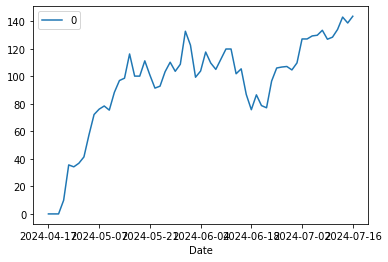

In [15]:
pnl.cumsum().plot()